# EDA and Sentiment Analysis

In this notebook we will begin further Exploratory Data Analysis on our cleaned dataset targeted to the top 5 cities in Ontario with the most amount of user reviews. We will also perform sentiment analysis using Natural Languagr Processing, and instantiate some models to evaluate the performance.

Sources:
- "Python remove character from string" by Pankaj [*(JournalDev)*](https://www.journaldev.com/23674/python-remove-character-from-string)
- [*Pandas*](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html)
- [*GeeksForGeeks*](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)
- "How To Perform Sentiment Analysis in Python 3 Using the Natural Language Toolkit (NLTK)" by Shaumik Daityari [*(Digital Ocean)*](https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk)
- "Making Natural Language Processing easy with TextBlob" by Akash [*(Analytics Vidhya*](https://www.analyticsvidhya.com/blog/2021/10/making-natural-language-processing-easy-with-textblob/)

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from collections import Counter
import joblib

import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import accuracy_score,mean_squared_error,plot_confusion_matrix, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from xgboost import XGBClassifier

from wordcloud import WordCloud, STOPWORDS

from textblob import TextBlob, Word, Blobber
from textblob.taggers import NLTKTagger

In [27]:
data = pd.read_csv('../Data/GTA_updated 2.csv')

In [7]:
data.columns

Index(['business_id', 'name', 'city', 'state', 'latitude', 'longitude',
       'stars', 'attributes', 'categories', 'user_id', 'review_stars', 'text',
       'review_counts', 'year', 'text_word_count'],
      dtype='object')

In [5]:
data['text'].head()

0    My girlfriend and I went for dinner at Emerald...
1    ***No automatic doors, not baby friendly!*** I...
2    Horrible service,\nI went there tonight with m...
3    I've been a frequent at this place for years, ...
4    We chose this restaurant for our Chinese New Y...
Name: text, dtype: object

In [6]:
print(data.shape)
data.head(2)

(328594, 15)


,business_id,name,city,state,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,review_counts,year,text_word_count
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,43.605499,-79.652289,2.5,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...",2K62MJ4CJ19L8Tp5pRfjfQ,3.0,My girlfriend and I went for dinner at Emerald...,134,2017,242
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,43.605499,-79.652289,2.5,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...",SuOLY03LW5ZcnynKhbTydA,3.0,"***No automatic doors, not baby friendly!*** I...",134,2016,43


We will create a new column to denote positive reviews, which are reviews of 4.0 and 5.0, with a '1' and negative reviews, which are 0 to 3.0 with a '0' as a new feature in our dataset.

In [29]:
data['pos_neg']  = np.where(data['review_stars']>3,1,0)
data['pos_neg'].value_counts()

1    204088
0    124506
Name: pos_neg, dtype: int64

<Figure size 720x576 with 0 Axes>

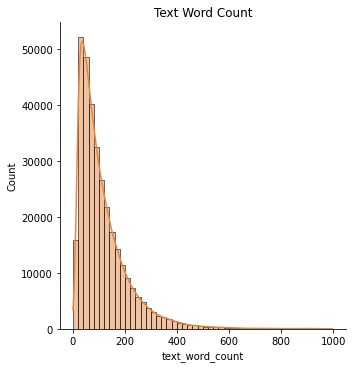

In [22]:
plt.figure(figsize=(10,8))
sns.displot(data['text_word_count'], kde=True, bins=50, color='#e28743')
plt.title('Text Word Count')
plt.savefig('../Images/Text_Word_Count.png')

In [9]:
data.groupby('stars')['text_word_count'].mean()

stars
1.0    103.649485
1.5    104.701192
2.0    112.861532
2.5    116.998572
3.0    119.725041
3.5    116.753256
4.0    112.533148
4.5    106.177263
5.0     89.324934
Name: text_word_count, dtype: float64

In [10]:
data.groupby('review_stars')['text_word_count'].mean()

review_stars
1.0    127.300098
2.0    134.338063
3.0    131.525405
4.0    116.493259
5.0     91.723041
Name: text_word_count, dtype: float64

As we can see from above, the lower a restaurant is rated, the more the amount of words in a review, which would suggest there might be more to give feedback on, instead of praise.

In [11]:
data.groupby('stars')['review_counts'].mean()

stars
1.0      8.917526
1.5     23.384968
2.0     42.666162
2.5     79.736571
3.0    140.821076
3.5    180.764381
4.0    230.920322
4.5    355.813253
5.0     70.697613
Name: review_counts, dtype: float64

In [12]:
data.groupby('review_stars')['review_counts'].mean()

review_stars
1.0    140.680799
2.0    171.956781
3.0    192.035489
4.0    214.573123
5.0    223.023317
Name: review_counts, dtype: float64

However, that being said, the higher rated a restaurant, the more the positive reviews.

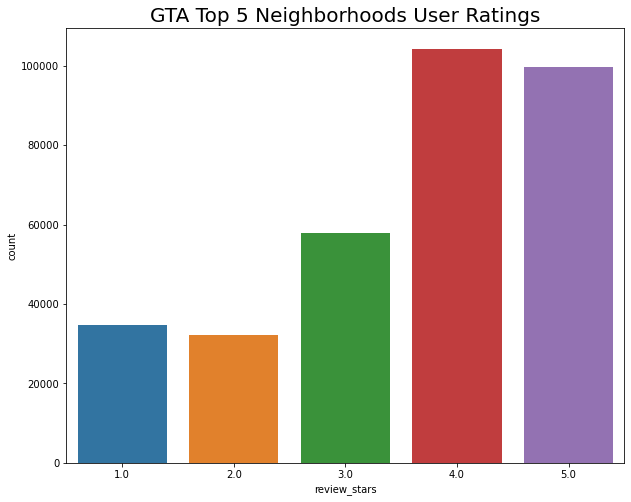

In [13]:
plt.subplots(figsize=(10,8))
sns.countplot(x=data['review_stars'])
plt.title('GTA Top 5 Neighborhoods User Ratings', fontsize=20)
plt.savefig('../Images/GTA_Top5_review_stars.png')
plt.show()

In [14]:
print({"Mean Restaurant Stars" : data['stars'].mean()})
data['stars'].value_counts()

{'Mean Restaurant Stars': 3.621262104603249}


4.0    112993
3.5    106337
3.0     52637
4.5     33109
2.5     16103
2.0      4622
5.0      1508
1.5      1091
1.0       194
Name: stars, dtype: int64

In [15]:
print({"Mean Review Stars" : data['review_stars'].mean()})
data['review_stars'].value_counts()

{'Mean Review Stars': 3.6163928738808377}


4.0    104290
5.0     99798
3.0     57765
1.0     34602
2.0     32139
Name: review_stars, dtype: int64

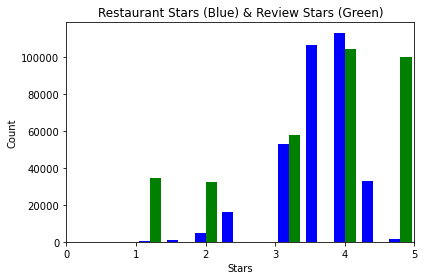

In [23]:
y_s = data['stars']
y_rs = data['review_stars']
colors = ['b','g']

fig, ax_stars = plt.subplots()
ax_stars.hist([y_s,y_rs],color=colors)
ax_stars.set_xlim(0,5)
ax_stars.set_xlabel("Stars")
ax_stars.set_ylabel("Count")
plt.title('Restaurant Stars (Blue) & Review Stars (Green)')
plt.tight_layout()
plt.savefig('../Images/restaurant_stars_review_stars.png')
plt.show()

In this next part, we will split up positive and negative reviews as we had determined them, in order to compare the differences between the two. 

In [28]:
onestar = data[data['review_stars'] == 1.0]
twostar = data[data['review_stars'] == 2.0]
threestar = data[data['review_stars'] == 3.0]
negative_reviews = [onestar, twostar, threestar]
negative_reviews = pd.concat(negative_reviews)
print(negative_reviews.shape)
negative_reviews.head(2)

(124506, 15)


,business_id,name,city,state,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,review_counts,year,text_word_count
2,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,43.605499,-79.652289,2.5,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...",lymyUak6KNcNKoDbK87MiQ,1.0,"Horrible service,\nI went there tonight with m...",134,2014,220
5,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,43.605499,-79.652289,2.5,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...",agqWketq-FhYwVmRyli4jA,1.0,I went at 230 on a Monday. It was dimsum \n\nI...,134,2017,90


In [9]:
# Instantiate count vectorizer
cvec = CountVectorizer(stop_words='english')

In [10]:
X = negative_reviews['text']
y = negative_reviews['review_stars']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# Fit & transform the vectorizer 
cvec_fit = cvec.fit_transform(X_train)

# Transform
Xcvec_test = cvec.transform(X_test)

In [11]:
XCV = pd.DataFrame(cvec_fit.toarray(), 
                          columns=cvec.get_feature_names())

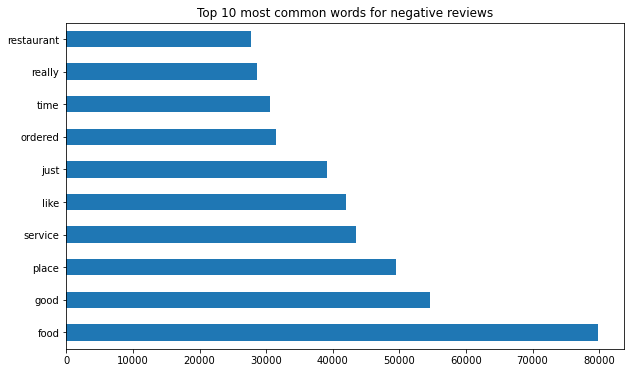

In [24]:
# plot top occuring negative words
plt.figure(figsize=(10, 6))
plt.xlabel('words')
plt.ylabel('counts')
plt.subplot(title='Top 10 most common words for negative reviews')
plt.savefig('../Images/Top10words_neg.png')
XCV.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

In [ ]:
# due to the file size and density, this code had to be coded out in order to reduce memory use which was affecting the whole notebook
# kindly refer to the image in the presentation slides
# px.set_mapbox_access_token("pk.eyJ1IjoiZGVicmFnb2VpIiwiYSI6ImNsMzhoMWoxdTAweW0zY3Q5ZDdwdnBnZXoifQ.1IE1CXqdKEeUmNA-qTPmGQ")
# px.scatter_mapbox(data, lat="latitude", lon="longitude", color="stars", size='review_counts' ,
                   size_max=30, zoom=3, width=600, height=400)

## Modeling

First we will take a look at our baseline results and then use Vader in the next section.

### Logistic Regression

In [14]:
Xp_train, Xp_test, yp_train, yp_test = model_selection.train_test_split(data['text'], data['pos_neg'],test_size=0.3, random_state=42)
print(Xp_train.shape)
print(Xp_test.shape)
print(yp_train.shape)
print(yp_test.shape)

(230015,)
(98579,)
(230015,)
(98579,)


In [15]:
cvecp = CountVectorizer(min_df=100, ngram_range=(1, 1),stop_words='english')
Xpp_train = cvecp.fit(Xp_train).transform(Xp_train) 
Xpp_test = cvecp.transform(Xp_test)
Xpp_train.shape

(230015, 6532)

In [16]:
logreg = LogisticRegression(max_iter=500,solver='liblinear').fit(Xpp_train,yp_train)
   
print(f"Logistic Regression train set: {logreg.score(Xpp_train, yp_train)}")
print(f"Logistic Regression test set: {logreg.score(Xpp_test, yp_test)}")
print ("Logistic Regression MSE: ", mean_squared_error(yp_test, logreg.predict(Xpp_test)))

Logistic Regression train set: 0.8809686324804904
Logistic Regression test set: 0.8666044492234655
Logistic Regression MSE:  0.13339555077653456


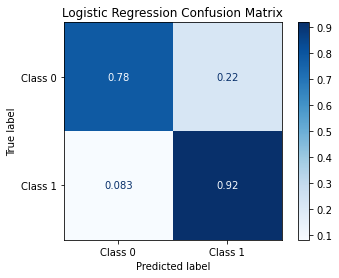

In [17]:
cm = plot_confusion_matrix(logreg, Xpp_test, yp_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
cm.ax_.set_title('Logistic Regression Confusion Matrix');

The next model we will use to evaluate our training and test sets is XGBoost.

### XGBoost

In [19]:
XGB_model = XGBClassifier(random_state=1)
XGB_model.fit(Xpp_train, yp_train)

print(f"XGBoost train set: {XGB_model.score(Xpp_train, yp_train)}")
print(f"XGBoost test set: {XGB_model.score(Xpp_test, yp_test)}")
print ("XGBoost MSE: ", mean_squared_error(yp_test, XGB_model.predict(Xpp_test)))

XGBoost train set: 0.8667043453687803
XGBoost test set: 0.851286785217947
XGBoost MSE:  0.14871321478205296


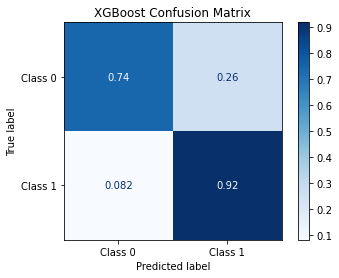

In [20]:
cm = plot_confusion_matrix(XGB_model ,Xpp_test, yp_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
cm.ax_.set_title('XGBoost Confusion Matrix');

Logistic regression performed slightly better than XGBoost for our baseline model. Next we will tokenize our text and save it for our recommender system as both train and test scores are functioning well.

In [65]:
data['text_clean'] = data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['text_clean'] = data['text_clean'].str.replace('[^\w\s-]', '', regex=True)
stopwords = set(stopwords.words('english'))
data['text_clean'] = data['text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
data['text_clean'] = data['text_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [32]:
data.to_csv('../Data/GTA_sentimentt.csv', index = False)

### Vader Sentiment Analysis

The advantages of using VADER on our project are because it works very well on social media type text whilst readily generalizing to multiple domains and it does not severely suffer from a speed-performance tradeoff (- Source: GA DSIR 222).

In [79]:
data = pd.read_csv('../Data/GTA_sentimentt.csv')

In [80]:
data['text_clean'] = data['text_clean'].astype('object')

In [81]:
data['text_clean'] = data['text_clean'].str.replace('\d+','', regex=True)

In [82]:
to_drop = ['latitude', 'longitude', 'stars', 'review_stars']
df = data.drop(to_drop, axis=1)

In [50]:
corpus = (data['text_clean'])
corpus[0]

'girlfriend went dinner emerald chinese thursday night workout arrived around 730pm seated short wait browsing menu brief discussion waiter ordered seafood noodle 3 item mix meat plate bbq pork chicken duck food came soon thereafter hot delicious large portion lot seafood seafood noodle mix meat plate came good cut meat correct sauce meal received fortune cooky dessert food food good quality ingredient tasted fresh dish tasted well made food average nothing stood even though quite hungry price price high comparative chinese cuisine comparable large western restaurant chain service service average slightly average common malaise chinese restaurant poor service waiterwaitresses overworked impatient unattentive emerald chinese exception waiting staff restaurant appear rushed impatient service need met staff rushed grumpy decor emerald tasteful decoration comfortable chair nice tablecloth sufficient room navigate table overall good meal large portion received average service paid slightly 

In [56]:
#instantiate SIA
sia = SentimentIntensityAnalyzer()
#Get polarity scores
sia.polarity_scores(corpus[0])

{'neg': 0.059, 'neu': 0.788, 'pos': 0.154, 'compound': 0.9393}

In [15]:
dfs.sort_values(by = 'pos', ascending = False).head()

,neg,neu,pos,compound,text_clean
109061,0.0,0.276,0.724,0.9833,love it super kid friendly great margarita ama...
38484,0.0,0.285,0.715,0.9753,a fantastic dinner and wonderful host thank yo...
272708,0.0,0.291,0.709,0.9805,delicious healthy good price definitely would ...
269794,0.0,0.328,0.672,0.9371,huge good cheap pizzagoodforkids true restaura...
200210,0.0,0.358,0.642,0.9113,fantastic delecious food very clean thanks for...


In [16]:
dfs.sort_values(by = 'neg', ascending = False).head()

,neg,neu,pos,compound,text_clean
309792,0.415,0.585,0.000,-0.8542,just stopped by for a bottle of water and ice ...
312360,0.390,0.610,0.000,-0.9276,this pizza wa burnt with no sauce the garlic b...
232151,0.382,0.487,0.130,-0.9476,most abusive disrespectful treatment of senior...
212118,0.380,0.540,0.080,-0.9923,horrible food they have cut somethings from th...
246181,0.367,0.492,0.142,-0.9822,although i love italian food but i think the f...
